<h1 style="text-align:center;">CeMiA Desktop</h1>
<h4 style="text-align:center;">Cellular Mitochondrial Analyzer Ver. 0.5.1b</h4>
<h3 style="text-align:center;">Kashatus Lab @ UVA</h3>


## Import necessary libraries
##### Just run the following block of code, you are not expected to enter any data here.

In [2]:
#Base Libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
import cv2


#Interaction
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, Checkbox, FloatSlider, Dropdown
from IPython.display import clear_output

#Core Functions
import cemia5 as cemia

## Locate and Sample Files

#### You are supposed to enter the relative address of the files (use . if the images are in the same folder as this file)


In [3]:
address,file_list = cemia.address()

Where are the files located?

test


### How many files to analyze?

#### You should enter the maximum number of the sample files that you want to initiallay analyze for parameter tuning purposes.
##### Don't worry about analyzing all your data at this moment. After parameter tuning you can analyze all of them in the last step


In [4]:
how_many = cemia.how_many(file_list)


How many files to sample? (If possile)
Please enter a valid integer value below 8
4


##### Just run the following block of code, you are not expected to enter any data here.

In [5]:
random_files = cemia.random_files(address,file_list,how_many)

These files were randomly selected:
 ['HEK3 MAP2K f26.tif']


### Lets find and separate individual cells in the sample images
##### Just run the following block of code, you are not expected to enter any data here.

In [6]:
layout = widgets.Layout(width='800px')

print('How do you want to extract the cells from images?')
extract_method = widgets.Select(
    options=['Assisted Automatic (Pro)'], #'Fully Automatic'
    description='Method:',
    disabled=False
)
display(extract_method)
threshold_pro = []
abspath = address + '/temp'

How do you want to extract the cells from images?


Select(description='Method:', options=('Assisted Automatic (Pro)',), value='Assisted Automatic (Pro)')

##### The next block of code is designed to help you to identify individual nuclei in the image. While in most cases the default values will do a good job, but in some cases you may find it useful to tune the values of different parameters, and find a combination that works best for your dataset.
<p>Correct Nucleus: This feature tries to reconstruct the shape of the poorly illuminated nuclei in the image.</p>
<p>Diffused Background: In rare cases that your images suffer from extremely low contrast, this option may help.</p>
<p>Make sure your settings work good on all your sample images by selecting different images from the dropdown menu.</p>

In [7]:
layout = widgets.Layout(width='800px')
nuc_mask = []

Intensity_threshold = [75]
Size_threshold = [1000]
correct_cells = [True]
neighorhood = [50]
mito_threshold = [75]
dialation = 50
empty_cell_thresh = [0]
nuc_correction = [True]
showimg = True
diffused_bg = [False]


if extract_method.value == 'Fully Automatic':
    for file in random_files:

        fullpath_input = address + '/' + file
        abspath = address + '/temp'
        namestring = file[:file.rfind('.')] + '.tif'
        print('Working on:', file)

        try:
            cemia.auto_segmentation(fullpath_input, abspath, namestring,Threshold,showimg,dilation, correct, Intensity_threshold[-1], Size_threshold[-1],empty_cell_thresh[-1],hide=False)
        
        except:
            print('{} is not a valid image file, trying the next file.'.format(file))
            pass
else:
    @interact(file=random_files, Intensity_Threshold=IntSlider(min=1,max=50,step=1,value=10,continuous_update=False,layout=layout),
              Size_Threshold=IntSlider(min=500,max=5000,step=250,value=1000,continuous_update=False,layout=layout),
              correct=Checkbox(value=True,description='Correct Nucleus',layout = layout),
              diffuse=Checkbox(value=False,description='Diffused background',layout = layout))
    
    def segment_nucleus(file,Intensity_Threshold, Size_Threshold, correct, diffuse):
        
        fullpath_input = address + '/' + file
        abspath = address + '/temp'
        namestring = file[:file.rfind('.')] + '.tif'
        Intensity_threshold.append(Intensity_Threshold)
        Size_threshold.append(Size_Threshold)
        diffused_bg.append(diffuse)
        nuc_correction.append(correct)
        
        
        try:        
            mask = cemia.nucleus_filtering(fullpath_input, abspath, Intensity_Threshold, Size_Threshold,True,correct, diffused=diffuse)
            nuc_mask.append(mask)
        except:
            print('{} is not a valid image file, trying the next file.'.format(file))
            pass


print('You can go to next step!')


interactive(children=(Dropdown(description='file', options=('HEK3 MAP2K f26.tif',), value='HEK3 MAP2K f26.tif'…

You can go to next step!


##### Just run the following block of code, you are not expected to enter any data here.

In [8]:
try:
    if ((len(Intensity_threshold) == 0) & (extract_method.value == 'Assisted Automatic (Pro)')):
        print('#############')
        print('Please go back and set a threshold value by moving the sliders')
        print('#############')
except:
    print('#############')
    print('Please go back and set a threshold value by moving the sliders, or select a fully automatic method for analysis.')
    print('#############')

##### The next block of code is designed to help you to identify and separate individual cells in the image. While in most cases the default values will do a good job, but in some cases you may find it useful to tune the values of different parameters, and find a combination that works best for your dataset.
<p><b>Threshold:</b> The intensity threshold for mitochondria</p>
<p><b>Neighborhood:</b> The radial distance around the nuclei to search for mitochondria. (to identify ghost cells)</p>
<p><b>Empty Cell Threshold:</b> The minimum accepatble amount of mitochondrial content around a cell (to identify ghost cells)</p>
<p><b>Segment Cells:</b> This item should be checked in order to separate the cells from the image.</p>

##### Note: Every time you select a new cell, while the segment cell is checked, it will automatically start to segment the cells in the image, which may take some time. Once segmentation is done, the segmented cells will show up.

In [10]:
correct_cells = [True]
neighorhood = [45]
mito_threshold = [65]

if extract_method.value == 'Assisted Automatic (Pro)':
    @interact(file=random_files, Threshold=IntSlider(min=60,max=100,step=2,value=65,continuous_update=False,layout=layout),
              dilation=IntSlider(min=35,max=100,step=5,value=45,continuous_update=False,description='Neighborhood',layout=layout),
              empty_cell_threshold=IntSlider(min=0,max=250000,step=2500,value=25000,continuous_update=False,description='Empty Cell Thresh',layout=layout),
              showimg=Checkbox(value=False,description='Segment Cells',layout = layout),
              correct=Checkbox(value=True,description='Remove Ghost Cells',layout = layout))

    def segment_cell(file,Threshold, dilation,empty_cell_threshold,showimg, correct):
        
        fullpath_input = address + '/' + file
        abspath = address + '/temp'
        namestring = file[:file.rfind('.')] + '.tif'
        mito_threshold.append(Threshold)
        empty_cell_thresh.append(empty_cell_threshold)
        
        try:
            mask_blue=cemia.auto_segmentation(fullpath_input, abspath, namestring,Threshold,showimg,dilation, correct, Intensity_threshold[-1], Size_threshold[-1],empty_cell_thresh[-1], hide=False,nuc_correct=False,diffused=diffused_bg[-1])

        except:
            print('{} is not a valid image file, try another file.'.format(file))
            pass


        correct_cells.append(correct)
    #print('Done! Go to next step.')
else:
    print('You have already used automatic segmengation. Proceed to the next step!')

interactive(children=(Dropdown(description='file', options=('HEK3 MAP2K f26.tif',), value='HEK3 MAP2K f26.tif'…

## Segment Sample Cells
##### There are two different method available to help you to segment your mitochondrial network. You can test them and then decide which one works for your dataset better.
###### Note: once you selected a method, go and run the next cell. Rerunning the same cell may reset your selection.

In [11]:
filter_method = widgets.Dropdown(options=['Let It Go','Not One of Us'],description='Filter:')
print('\nLet It Go: Better option for images with very low background intensity.')
print('\nNot One of Us: Signal separation based on the distribution of background intensity in the nucleus area.')
display(filter_method)


Let It Go: Better option for images with very low background intensity.

Not One of Us: Signal separation based on the distribution of background intensity in the nucleus area.


Dropdown(description='Filter:', options=('Let It Go', 'Not One of Us'), value='Let It Go')

<p><b>Strength:</b> Determines the strength of the background removal.</p>
<p><b>Harshness:</b> Determines if the background removal is harshly applied to a small group of images, or wether it is more softly applied to a wider range of images.</p>
<p></p>
<p><b>Adaptive Options</b></p>
<p>Settings for the adaptive method are effective only if the adaptive method is selected.</p>
<p><b>Tile Size:</b> The size of the tile over which the adpative function samples data and compares with the reference intensity.</p>
<p><b>Adaptive Power:</b> The strength of the adaptive function in correcting the threshold.</p>
<p><b>Adaptive Footprint:</b> Determines the the correction factor should affect a wide, or short range of of images with different background intenisties.</p>
<p><b>Remove Debries:</b> Tries to remove noisty objects created in the image as a result of using different filters</p>


In [13]:
thresh_moon1 = [5]
thresh_moon2 = [3]
thresh_adamask1 = [3]
thresh_adamask2 = [0.5]
thresh_adamask3 = [0]
thresh_median_mask = [2]
thresh_median_mask2 = [1]
thresh_median_signal = [1]
out = []
adaptive_th = [True]
window_size_th = [16]
steepness_th = [0.5]
equalizer_th = [0.15]
remove_debries_th = [True]

tmp1 = []
tmp2 = []

sample_files = []

try:
    for file in os.listdir(address+'/temp/good/'):

        sample_files.append(file)
    #del(sample_files[0])
except:
    
    print('\nThere is nothing to analyze!')
    print('\nYou must at least segment one cell before you proceed!')
    print('\nPlease go to the last step and select "Segment Cell" for at least one cell.\n')

print('Selected Method: ',filter_method.value)

if filter_method.value=='Not One of Us':
    @interact(thresh9=IntSlider(value=2, min=1, max=5,step=1, description='Harshness:',continuous_update=False,layout = layout),
              thresh10=IntSlider(value=1, min=1, max=10,step=1, description='Strength:',continuous_update=False,layout = layout),
              adapt=Checkbox(value=False,description='Adaptive Threshold',layout = layout),
              window=Dropdown(options=[8,16,32,64,128,256,512], value=16, description='Tile Size',layout = layout),
              equalizer=FloatSlider(value=0.15, min=0.1, max=0.5,step=0.05, description='Ada Power:',continuous_update=False,layout = layout),
              steepness=FloatSlider(value=0.5, min=0.25, max=1.5,step=0.25, description='Ada Footprint:',continuous_update=False,layout = layout),
              debries=Checkbox(value=True,description='Remove Debries',layout = layout))
    

    def filter_selection3(thresh10, thresh9,adapt,window, equalizer,steepness, debries):

        thresh_median_mask.append(thresh9)
        thresh_median_mask2.append(thresh10)
        adaptive_th.append(adapt)
        window_size_th.append(window)
        steepness_th.append(steepness)
        equalizer_th.append(equalizer)
        remove_debries_th.append(debries)

        
        for file in sample_files:
           
            try:
                pic2 = plt.imread(address+'/temp/good/' + file)

                print('Strength: ', thresh10)
                print('Harshness: ', thresh9)
                print('File: ',address+'/temp/good/' + file)

                #_,_, binarized, blue_mask = cemia.behind_the_moon_filter(pic2, 60,2.5,1,bg_harshness=-0.5,sig_harshness=thresh_median_mask[-1],sig_strength=thresh_median_mask2[-1], cleanup=False, method=2)
                _,_, binarized, blue_mask = cemia.behind_the_moon_filter(pic2, 60,2.5,1,bg_harshness=-0.5,sig_harshness=thresh_median_mask[-1],sig_strength=thresh_median_mask2[-1], cleanup=False, method=2, adaptive=adaptive_th[-1], window_size=window_size_th[-1],equalizer=equalizer_th[-1],steepness=steepness_th[-1], remove_debries=remove_debries_th[-1])
                out.append(binarized)
                plt.figure(figsize=(20,20))
                #plt.subplot(131)
                #plt.title('Nucleus mask used for background measurement')
                #plt.axis('off')
                #plt.imshow(blue_mask)
                plt.subplot(121)
                plt.title('Original image')
                plt.imshow(pic2,'gray')
                plt.axis('off')

                plt.subplot(122)
                plt.title('Binarized Image')
                plt.axis('off')
                plt.imshow(binarized,'gray')
                plt.show()

            except:
                print('\n{} is not a valid image file, trying the next file.'.format(file))
                pass
                        
elif filter_method.value=='Let It Go':
    @interact(thresh11=FloatSlider(value=-0.5, min=-1.5, max=1,step=0.1, description='Harshness:',continuous_update=False,layout = layout),
              adapt=Checkbox(value=False,description='Adaptive Threshold',layout = layout),
              window=Dropdown(options=[8,16,32,64,128,256,512], value=16, description='Tile Size',layout = layout),
              equalizer=FloatSlider(value=0.15, min=0.1, max=0.5,step=0.05, description='Ada Power:',continuous_update=False,layout = layout),
              steepness=FloatSlider(value=0.5, min=0.25, max=1.5,step=0.25, description='Ada Footprint:',continuous_update=False,layout = layout),
              debries=Checkbox(value=True,description='Remove Debries',layout = layout))        
    
    def filter_selection3(thresh11,adapt,window, equalizer,steepness, debries):

        thresh_median_signal.append(thresh11)
        adaptive_th.append(adapt)
        window_size_th.append(window)
        steepness_th.append(steepness)
        equalizer_th.append(equalizer)
        remove_debries_th.append(debries)

        for file in sample_files:
           
            try:
                pic2 = plt.imread(address+'/temp/good/' + file)

                print('Harshness: ', thresh11)
                print('File: ',address+'/temp/good/' + file)
                #_,_,binarized, blue_mask = cemia.behind_the_moon_filter(pic2, 60,2.5,1,bg_harshness=thresh_median_signal[-1],sig_harshness=2,sig_strength=1, cleanup=False, method=1)
                _,_,binarized, blue_mask = cemia.behind_the_moon_filter(pic2, 60,2.5,1,bg_harshness=thresh_median_signal[-1],sig_harshness=2,sig_strength=1, cleanup=False, method=1, adaptive=adaptive_th[-1], window_size=window_size_th[-1],equalizer=equalizer_th[-1],steepness=steepness_th[-1], remove_debries=remove_debries_th[-1])
                out.append(binarized)
                plt.figure(figsize=(20,20))
                #plt.subplot(121)
                #plt.title('Nucleus mask used for background measurement')
                #plt.axis('off')
                #plt.imshow(blue_mask)
                plt.subplot(121)
                plt.title('Original image')
                plt.imshow(pic2,'gray')
                plt.axis('off')

                plt.subplot(122)
                plt.title('Binarized Image')
                plt.axis('off')
                plt.imshow(binarized,'gray')
                plt.show()
            except:
                print('\n{} is not a valid image file, trying the next file.'.format(file))
                pass
                        

Selected Method:  Not One of Us


interactive(children=(IntSlider(value=1, continuous_update=False, description='Strength:', layout=Layout(width…

## Analyze All The Images
##### Just run the following block of code, and check whether  everything looks alright or not. If some thing doesn't seem right, you can go back and fix it. You are not expected to enter any data here.

In [14]:
print('The following settings will be used to analyze all the images!')
print('**************************************************************')
print('\nMethod for cell separation: ',extract_method.value)

if extract_method.value == 'Assisted Automatic (Pro)':
    print('Nucleus Sensitivity: ',Intensity_threshold[-1])
    print('Nucleus Size Limit: ',Size_threshold[-1])
    print('Mitochondria Sensitivity: ',mito_threshold[-1])
    print('Mitochondrial Neighborhood Search',neighorhood[-1])
    print('Cell Correction:', correct_cells[-1])
    print('Empty Cell Removal Threshold:', empty_cell_thresh[-1])

if extract_method.value == 'Fully Automatic':
    print('Nucleus Sensitivity: ',Intensity_threshold[-1])
    print('Nucleus Size Limit: ',Size_threshold[-1])
    print('Mitochondria Sensitivity: ',mito_threshold[-1])
    print('Mitochondrial Neighorhood Search', neighorhood[-1])
    print('Cell Correction:', True)
    print('Empty Cell Removal Threshold:', empty_cell_thresh[-1])
    

print('\nFilter for binarizing the cells: ',filter_method.value)

if filter_method.value == 'Not One of Us':
    try:
        print('\nHarshness for "Not One of Us" algorithm: ',thresh_median_mask[-1])
        print('\nStrength for "Not One of Us" algorithm: ',thresh_median_mask2[-1])
        if adaptive_th[-1]:
            print('\nAdaptive Thgresholding Selected')
            print('\nTile Size: ',window_size_th[-1])
            print('\nAdaptive Function Power: ',equalizer_th[-1])
            print('\nAdaptive Function Footprint: ',steepness_th[-1])
            print('\nRemove Leftover debries: ',remove_debries_th[-1])

    except:
        print('\n### ERROR: It seems you have not set your treshold values!\nIf you continue, the analysis will fail!\nGo back and run the previous cells.')
        pass

elif filter_method.value == 'Let It Go':
    try:
        print('\nHarshness for "Let It Go" algorithm: ',thresh_median_signal[-1])
        if adaptive_th[-1]:
            print('\nAdaptive Thgresholding Selected')
            print('\nTile Size: ',window_size_th[-1])
            print('\nAdaptive Function Power: ',equalizer_th[-1])
            print('\nAdaptive Function Footprint: ',steepness_th[-1])
            print('\nRemove Leftover debries: ',remove_debries_th[-1])
            
    except:
        print('\n### ERROR: It seems you have not set your treshold values!\nIf you continue, the analysis will fail!\nGo back and run the previous cells.')
        pass

The following settings will be used to analyze all the images!
**************************************************************

Method for cell separation:  Assisted Automatic (Pro)
Nucleus Sensitivity:  10
Nucleus Size Limit:  1000
Mitochondria Sensitivity:  65
Mitochondrial Neighborhood Search 45
Cell Correction: True
Empty Cell Removal Threshold: 25000

Filter for binarizing the cells:  Not One of Us

Harshness for "Not One of Us" algorithm:  2

Strength for "Not One of Us" algorithm:  1


### What do you want to name your tabular data file?
##### Just name your file here.

In [16]:
output_filename = input('What is the name of output csv file?\nJust enter the name without .csv extension\nWe Will add the current date to the beginning of the file name!\n\n')


What is the name of output csv file?
Just enter the name without .csv extension
We Will add the current date to the beginning of the file name!

eeee


##### Just run this block of code, and then go and enjoy your time. Running this block of code may take few hours depending on the number of images that you have.
###### Pro Tip: If you have many images, run this block of code just before you call it a day! Then, go and enjoy your life outside the lab!

cells
cells is not a valid image file, trying the next file.
temp
temp is not a valid image file, trying the next file.
.DS_Store
.DS_Store is not a valid image file, trying the next file.
2019-12-3-t3.tsv
2019-12-3-t3.tsv is not a valid image file, trying the next file.
HEK3 MAP2K f26.tif

Please wait...
Number of Nuclei:  19
Linking 749 Mitochondria to 19 Cells

Number of mitochondria with obvious links to nuclei:  87
Assigning mitochondria with obvious links to respective nuclei...

Number of mitochondria with less obvious links:  7
Finding the best nuclei to assign mitochondria with less obvious links...

Number of floating mitochondria:  661
Assigning floating mitochondria to the most probable nuclei...

Number of mitochondria common between multiple nuclei:  1
Finding the best nuclei to assign mitochondria with multiple links
Cell 1 QC: Good
test/cells/good/HEK3 MAP2K f26_cell1_1024.tif
Cell 2 QC: Good
test/cells/good/HEK3 MAP2K f26_cell2_1024.tif
Cell 3 QC: Good
test/cells/good/

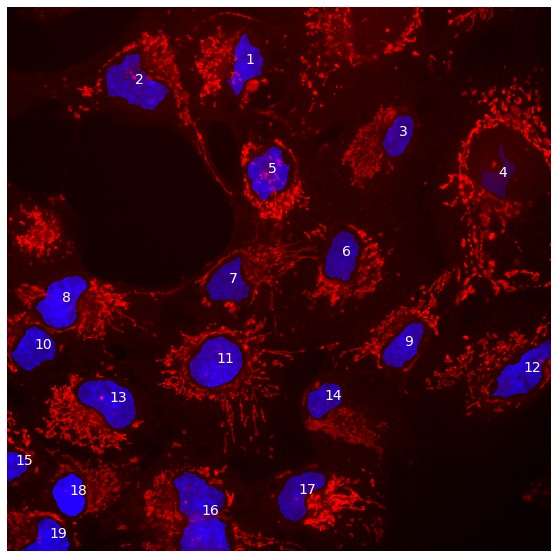

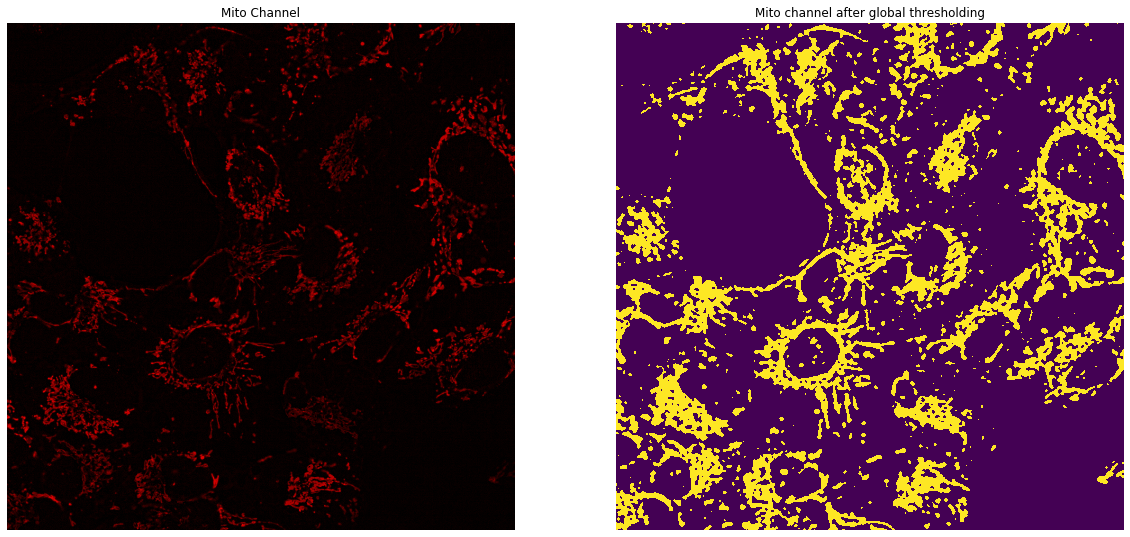

In [17]:
try:
    os.makedirs(address+'/cells')
except FileExistsError:
    pass

try:
    os.makedirs(address+'/cells/processed')
except FileExistsError:
    pass

try:
    os.makedirs(address+'/cells/processed/single_cells_binary')
except FileExistsError:
    pass

#try:
#    os.makedirs(address+'/cells/processed/single_cells')
#except FileExistsError:
#    pass


cell_list = os.listdir(address)


counter = 0
counter1 = 0

for file in file_list:

    fullpath_input = address + '/' + file
    abspath = address + '/cells'
    namestring = file[:file.rfind('.')] + '.tif'
    print(file)

    try:
        cemia.auto_segmentation(fullpath_input, abspath, namestring,mito_threshold[-1],True,neighorhood[-1], correct_cells[-1], Intensity_threshold[-1], Size_threshold[-1], empty_cell_thresh[-1], hide=True, nuc_correct=False, diffused=diffused_bg[-1])
    except:
        print('{} is not a valid image file, trying the next file.'.format(file))
        pass


print('Done with cutting cells!\nGoing to the filtering.\n')

cell_list = os.listdir(abspath+'/good')

if filter_method.value=='Not One of Us':
  
        for file in cell_list:
            fullpath_input = file
            abspath = address
                         
            try:
                pic2 = plt.imread(address+'/cells/good/' + file)

                print('\n\nProcessing File: ',address+'/cells/good/' + file)

                #img,_,binarized, blue_mask = cemia.behind_the_moon_filter(pic2, 60,2.5,1,bg_harshness=-0.5,sig_harshness=thresh_median_mask[-1],sig_strength=thresh_median_mask[-2], cleanup=False, method=2)
                img,_,binarized, blue_mask = cemia.behind_the_moon_filter(pic2, 60,2.5,1,bg_harshness=-0.5,sig_harshness=thresh_median_mask[-1],sig_strength=thresh_median_mask2[-1], cleanup=False, method=2, adaptive=adaptive_th[-1], window_size=window_size_th[-1],equalizer=equalizer_th[-1],steepness=steepness_th[-1], remove_debries=remove_debries_th[-1])
                cv2.imwrite(abspath + '/cells/processed/single_cells_binary/' + file[:file.rfind('.')]+'binarized.tif', binarized)

                #pic2 = cv2.imread(address+'/cells/good/' + file)
                cv2.imwrite(abspath + '/cells/processed/single_cells_binary/' + file, pic2)

            except:
                print('\n{} is not a valid image file, trying the next file.'.format(file))
                pass

        summary = pd.DataFrame(columns = ['Separation_Method','Filter', 'Num_files','Num_cells','Num_good','Num_bad'])

elif filter_method.value=='Let It Go':

    for file in cell_list:
        fullpath_input = file
        abspath = address

        try:
            pic2 = plt.imread(address+'/cells/good/' + file)

            print('\n\nProcessing File: ',address+'/cells/good/' + file)

            #img,_,binarized, blue_mask = cemia.behind_the_moon_filter(pic2, 60,2.5,1,bg_harshness=thresh_median_signal[-1],sig_harshness=2,sig_strength=1, cleanup=False, method=1)
            img,_,binarized, blue_mask = cemia.behind_the_moon_filter(pic2, 60,2.5,1,bg_harshness=thresh_median_signal[-1],sig_harshness=2,sig_strength=1, cleanup=False, method=1, adaptive=adaptive_th[-1], window_size=window_size_th[-1],equalizer=equalizer_th[-1],steepness=steepness_th[-1], remove_debries=remove_debries_th[-1])
            cv2.imwrite(abspath + '/cells/processed/single_cells_binary/' + file[:file.rfind('.')]+'binarized.tif', binarized)

            #pic2 = cv2.imread(address+'/cells/good/' + file)
            cv2.imwrite(abspath + '/cells/processed/single_cells_binary/' + file, pic2)

        except:
            print('\n{} is not a valid image file, trying the next file.'.format(file))
            pass

        summary = pd.DataFrame(columns = ['Separation_Method','Filter', 'Num_files','Num_cells','Num_good','Num_bad'])

print('\nDone with the filtering.\nInitial QC Check.\n')

#cemia.good_check(address)

print('\nInitial QC was skipped.\nStarting to analyze images.')

cell_list = os.listdir(abspath+'/cells/processed/single_cells_binary')

cemia.measurement(address,summary,cell_list,output_filename)


# The End!